# Empirical Checks for Regulated Growth and Finite-Band Irruption

This notebook implements the conservative linear growth equation

$$\ddot\delta_k + 2H\dot\delta_k + \left(\frac{c_s^2 k^2}{a^2} + \frac{\kappa_{\rm eff} k^4}{a^4} - 4\pi G\bar\rho\right)\delta_k = 0,$$

and uses it to compute a scale-dependent growth factor $D(k,a)$, a regulator-modified Jeans scale, and a corresponding suppression (or bounded instability band if $c_s^2(a)<0$ in a finite interval). The goal is not parameter fitting but an explicit parameter-to-observable map.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

np.set_printoptions(precision=4, suppress=True)


## Background: matter domination (baseline)

We start with an Einstein–de Sitter background to keep the mapping transparent. In these units, $H(a)=H_0\,a^{-3/2}$ and $\bar\rho(a)=3H(a)^2/(8\pi G)$.


In [20]:
# Normalized units
H0 = 1.0
Omega_m = 1.0
G = 1.0

def H(a):
    return H0 * np.sqrt(Omega_m / a**3)

def rho_bar(a):
    return 3 * H(a)**2 / (8 * np.pi * G)


## Model parameters

The conservative scaffold treats $\kappa_{\rm eff}>0$ as a gradient-energy regulator encoded in an effective pressure sector. The optional "spinodal window" is implemented by allowing $c_s^2(a)$ to become negative on a finite interval $a_{\rm on}<a<a_{\rm off}$.


In [21]:
# Regulator strength (length^2 in physical units; here dimensionless)
kappa_eff = 1e-4

# Baseline sound speed squared outside the spinodal window
cs2_out = 0.0

# Spinodal window controls (set cs2_in >=0 to disable irruption)
a_on = 0.03
a_off = 0.08
cs2_in = -2e-6  # negative values create a bounded intermediate-k instability when combined with kappa_eff>0

def cs2(a):
    if a_on < a < a_off:
        return cs2_in
    return cs2_out


## Growth equation in $\ln a$

We integrate in $\ln a$ to reduce stiffness when scanning over many $k$ values. The state is $(\delta,\,d\delta/d\ln a)$.


In [22]:
def growth_system(ln_a, y, k):
    a = np.exp(ln_a)
    delta, ddelta_dln = y
    Hval = H(a)
    rhoval = rho_bar(a)

    omega2 = (
        cs2(a) * (k**2) / (a**2)
        + kappa_eff * (k**4) / (a**4)
        - 4 * np.pi * G * rhoval
    )

    # EdS background gives d ln H / d ln a = -3/2, leading to the (3/2) friction term in ln a.
    d2delta_dln2 = -1.5 * ddelta_dln - (omega2 / (Hval**2)) * delta
    return [ddelta_dln, d2delta_dln2]


## Jeans scale with regulator

At fixed $a$, a conservative Jeans-like boundary for suppression/instability is obtained by solving

$$\frac{c_s^2(a) k^2}{a^2} + \frac{\kappa_{\rm eff} k^4}{a^4} = 4\pi G\bar\rho(a).$$

When $c_s^2(a)<0$ this can produce a finite band of intermediate scales where gravity plus negative compressibility wins, while ultraviolet modes remain stabilized by the $k^4$ term.


In [23]:
def kJ_comoving(a):
    # Solve quadratic in X = k^2/a^2: kappa_eff X^2 + cs2(a) X - 4πGρ = 0
    cs2a = cs2(a)
    rhoval = rho_bar(a)
    A = kappa_eff
    B = cs2a
    C = -4 * np.pi * G * rhoval
    disc = B**2 - 4*A*C
    if disc <= 0 or A <= 0:
        return np.nan
    X_pos = (-B + np.sqrt(disc)) / (2*A)
    if X_pos <= 0:
        return np.nan
    k2 = (a**2) * X_pos
    return np.sqrt(k2)


## Scan over modes and compute growth and suppression

We integrate from an early $a_i$ to $a_f$ and define a scale-dependent growth factor $D(k,a_f)$ by normalizing all modes to the smallest-$k$ mode.


In [24]:
from scipy.integrate import solve_ivp
import numpy as np

a_i = 1e-3
a_f = 1.0
ln_span = (np.log(a_i), np.log(a_f))

def solve_mode(k, y0=(1e-5, 1e-5)):
    sol = solve_ivp(
        growth_system,
        ln_span,
        y0,
        args=(k,),
        method="Radau",     # robust for stiff oscillatory systems
        t_eval=[ln_span[1]],# endpoint only
        rtol=1e-4,
        atol=1e-8,
        max_step=0.2        # coarse steps in ln a; adjust 0.05–0.5
    )
    if not sol.success or not np.isfinite(sol.y[0, -1]):
        return np.nan
    return sol.y[0, -1]


## Visualize the regulator-modified Jeans scale through time

This plot shows $k_J(a)$ across the interval. When $c_s^2(a)$ dips negative, the meaning shifts from pure "Jeans suppression" to a bounded competition between negative compressibility and the $k^4$ stabilizer.


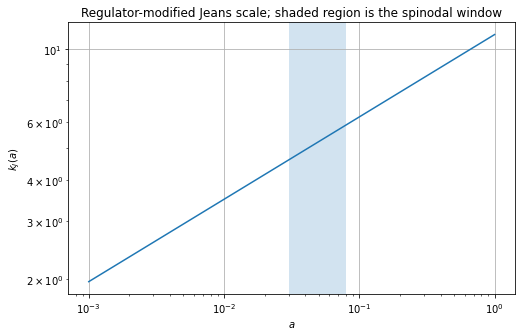

In [25]:
a_grid = np.logspace(np.log10(a_i), np.log10(a_f), 300)
kJ_vals = np.array([kJ_comoving(a) for a in a_grid])

plt.figure(figsize=(8, 5))
plt.loglog(a_grid, kJ_vals)
plt.axvspan(a_on, a_off, alpha=0.2)
plt.xlabel(r"$a$")
plt.ylabel(r"$k_J(a)$")
plt.title("Regulator-modified Jeans scale; shaded region is the spinodal window")
plt.grid(True)
plt.show()


## A simple power-spectrum proxy

For a first pass, take a primordial spectrum $P_{\rm prim}(k)\propto k^{n_s}$ and define a relative late-time spectrum by $P(k,a_f)\propto P_{\rm prim}(k)\,D(k,a_f)^2$. This is not a full Boltzmann pipeline; it is an explicit wedge illustrating how $(\kappa_{\rm eff},c_s^2(a))$ imprint a high-$k$ tail.


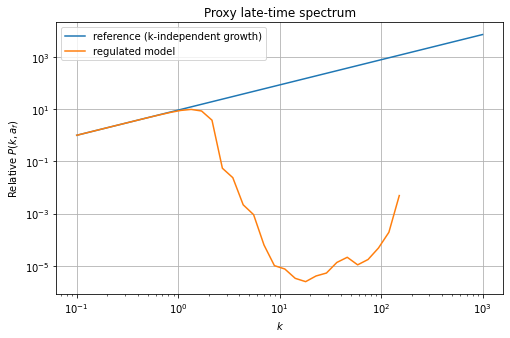

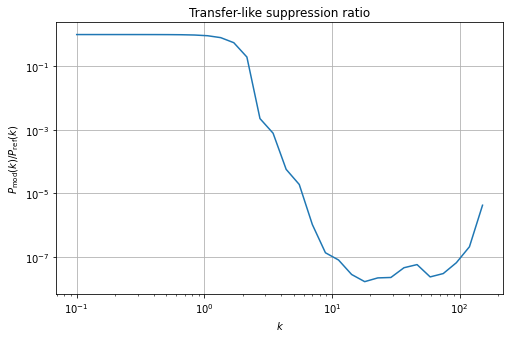

In [27]:
# D_af should already contain endpoint growth values (NaN if failed)

valid = np.isfinite(D_af)

if valid.sum() < 2:
    raise RuntimeError("Too few successful modes to normalize growth.")

# normalize relative to the smallest k that succeeded
first = np.where(valid)[0][0]

D_norm = np.full_like(D_af, np.nan)
D_norm[valid] = D_af[valid] / D_af[first]

n_s = 0.965
P_prim = k_vals**n_s

P_mod = P_prim * (D_norm**2)
P_mod /= P_mod[0]

# Baseline (no regulator) reference: D ~ a in EdS, so k-independent in this proxy.
P_ref = (k_vals**n_s)
P_ref /= P_ref[0]

plt.figure(figsize=(8, 5))
plt.loglog(k_vals, P_ref, label="reference (k-independent growth)")
plt.loglog(k_vals, np.abs(P_mod), label="regulated model")
plt.xlabel(r"$k$")
plt.ylabel(r"Relative $P(k,a_f)$")
plt.title("Proxy late-time spectrum")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
ratio = np.abs(P_mod / P_ref)
plt.loglog(k_vals, ratio)
plt.xlabel(r"$k$")
plt.ylabel(r"$P_{\rm mod}(k)/P_{\rm ref}(k)$")
plt.title("Transfer-like suppression ratio")
plt.grid(True)
plt.show()


## Notes for refinement

### Notes on Regulator Tuning and Extensions

To reproduce a strictly band-limited interval of *growth* (rather than pure suppression), one may tune the effective sound speed so that cₛ²(a) becomes negative only within a finite temporal window, while choosing κ_eff sufficiently large to stabilize the ultraviolet regime. Under these conditions, the band edges at a given scale factor a can be estimated by solving the dispersion relation ω²(k, a) = 0. The fastest-growing mode during the active window may then be approximated by maximizing the instantaneous growth exponent using a WKB analysis.

For a pipeline that is closer to observational practice, the next step is to replace the Einstein–de Sitter background with a realistic expansion history H(a) and to supply radiation-era initial conditions for δ_k at a chosen starting epoch a_i. The same regulator term then propagates forward through the evolution and appears in the late-time transfer function.
